In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

### Set hyperparameters

In [75]:
# output directory
output_dir = 'model_output/dense'

# training
epochs = 4
batch_size = 128

# vector-space embedding
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50 # highly likely 50 most frequent words are stopwords
max_review_length = 100
pad_type = trunc_type = 'pre' # reviews longer or shorter than max_review_length

# neural network architecture
n_dense = 64
dropout = 0.5

### Load data

In [35]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words,
                                                        skip_top=n_words_to_skip) 

In [36]:
x_train[0:6] # 0: padding, 1: starting char, 2: unknown, 3: most frequent, etc.

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [37]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [38]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [39]:
len(x_train), len(x_valid)

(25000, 25000)

### Restoring words from index

In [40]:
word_index = tensorflow.keras.datasets.imdb.get_word_index()

In [41]:
type(word_index)

dict

In [42]:
import itertools

In [43]:
dict(itertools.islice(word_index.items(), 0,10))

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008}

In [44]:
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

In [45]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [46]:
index_word = {v:k for k, v in word_index.items()}

In [47]:
index_word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [48]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [49]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [50]:
(all_x_train,_), (all_x_valid,_) = imdb.load_data()

In [51]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

### Preprocessing data

In [54]:
x_train = pad_sequences(x_train, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)

In [55]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [57]:
for x in x_train[0:10]:
    print(len(x))

100
100
100
100
100
100
100
100
100
100


In [58]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [59]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

### Design neural network

In [64]:
model = Sequential()

# first hidden layer (idea: embedding in word vector space is better than one-hot.
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())

# second hidden layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# third hidden layer
# model.add(Dense(n_dense, activation='relu'))
# modeladd(Dropout(dropout))

# output layer
model.add(Dense(1, activation='sigmoid'))

In [70]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           320000    
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                409664    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 729729 (2.78 MB)
Trainable params: 729729 (2.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile model

In [71]:
model.compile(loss='binary_crossentropy', optimizer='nadam',
              metrics=['accuracy'])

In [73]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir + "/weights.{epoch:02d}.hdf5")

### Train

In [77]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=[modelcheckpoint])

Epoch 1/4


2024-03-03 15:54:06.409805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 11s 43ms/step - loss: 0.5471 - accuracy: 0.6890 - val_loss: 0.3559 - val_accuracy: 0.8420
Epoch 2/4
  6/196 [..............................] - ETA: 5s - loss: 0.3226 - accuracy: 0.8737

/Users/jaejin/mambaforge/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 6s 28ms/step - loss: 0.2813 - accuracy: 0.8879 - val_loss: 0.3661 - val_accuracy: 0.8400
Epoch 3/4
196/196 [==============================] - 5s 26ms/step - loss: 0.1327 - accuracy: 0.9589 - val_loss: 0.4357 - val_accuracy: 0.8286
Epoch 4/4
196/196 [==============================] - 5s 25ms/step - loss: 0.0288 - accuracy: 0.9956 - val_loss: 0.5273 - val_accuracy: 0.8294


### Evaluate

In [78]:
model.load_weights(output_dir+"/weights.01.hdf5") # not zero-indexed

In [80]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 1s 1ms/step


In [81]:
y_hat[0]

array([0.28955695], dtype=float32)

In [82]:
y_valid[0]

0

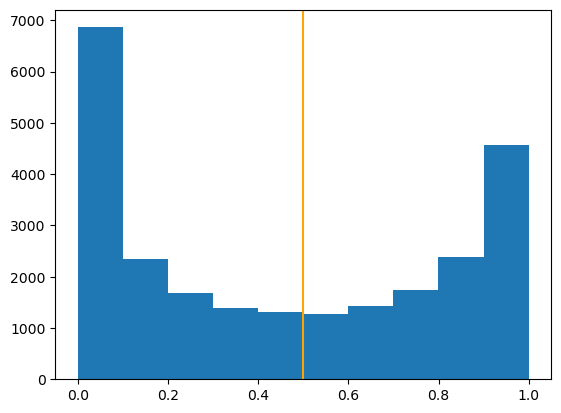

In [84]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [85]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [88]:
"{:0.2f}".format(pct_auc)

'92.58'

In [90]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [92]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [94]:
ydf.head(10)

,y_hat,y
0,0.289557,0
1,0.861545,1
2,0.425237,1
3,0.485016,0
4,0.991234,1
5,0.519052,1
6,0.586608,1
7,0.012677,0
8,0.805432,0
9,0.487689,1


In [95]:
' '.join(index_word[id] for id in all_x_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [96]:
' '.join(index_word[id] for id in all_x_valid[6])

"START originally supposed to be just a part of a huge epic the year 1905 depicting the revolution of 1905 potemkin is the story of the mutiny of the crew of the potemkin in odessa harbor the film opens with the crew protesting meat and the captain ordering the execution of the an uprising takes place during which the revolutionary leader is killed this crewman is taken to the shore to lie in state when the townspeople gather on a huge flight of steps overlooking the harbor czarist troops appear and march down the steps breaking up the crowd a naval squadron is sent to retake the potemkin but at the moment when the ships come into range their crews allow the to pass through eisenstein's non historically accurate ending is open ended thus indicating that this was the seed of the later bolshevik revolution that would bloom in russia the film is broken into five parts men and maggots drama on the an appeal from the dead the odessa steps and meeting the squadron br br eisenstein was a revo

In [104]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10) # wrong sentiment classification

,y_hat,y
680,0.903280,0
693,0.917516,0
710,0.924615,0
740,0.923780,0
778,0.946657,0
781,0.932975,0
1059,0.985964,0
1150,0.923348,0
1207,0.983167,0
1593,0.911202,0


In [105]:
' '.join(index_word[id] for id in all_x_valid[1059])

"START low budget but still creepy enough to hold your interest in another take off on the familiar frankenstein story this movie is also known as lady frankenstein the alluring frankenstein sara bay fresh from medical school arrives at her father's estate to find that he is still up to his old tricks baron frankenstein joseph cotten is murdered by his own creation and now his daughter decides to carry on the family tradition by creating herself a lover this is closer to being an eerie melodrama than horror flick supporting cast features mickey hargitay paul paul muller and herbert a rainy night could amplify the atmosphere still a fun watch"

In [106]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10) # another wrong sentiment classification

,y_hat,y
159,0.093847,1
187,0.086455,1
224,0.036659,1
248,0.057030,1
263,0.080768,1
300,0.054552,1
325,0.083068,1
345,0.083139,1
535,0.050018,1
667,0.040649,1


In [103]:
' '.join(index_word[id] for id in all_x_valid[224])

"START finally a true horror movie this is the first time in years that i had to cover my eyes i am a horror buff and i recommend this movie but it is quite gory i am not a big wrestling fan but kane really pulled the whole monster thing off i have to admit that i didn't want to see this movie my 17 year old dragged me to it but am very glad i did during and after the movie i was looking over my shoulder i have to agree with others about the whole remake horror movies enough is enough i think that is why this movie is getting some good reviews it is a refreshing change and takes you back to the texas chainsaw first one michael myers and jason and no cgi crap"